# ConvexNet v1版本：输入特征，特征用于预测核函数网络中的若干个权重W和若干个偏置B（核函数网络是指输入T输出Y的网络）

# 该版本的改进是输入了特征，特征可以影响T和Y之间的函数关系，不足是用实际业务数据进行训练后发现T和Y的关系不具有城市异质性（甚至对几乎所有特征都没有异质性）。

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep
from tqdm import tqdm
from torchmetrics.functional import r2_score

# 模型注意事项：
# 1. 实例化网络时需要输入T（treatment样本）、X（feature样本）和Y（output样本），原因是网络需要寻找合适的初始化参数，有利于训练时网络的收敛。
# 2. 参数kernel_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示核函数层只有1层，每层有100个节点，后者表示核函数层有3层，第一层50个节点，第二层100个节点，第三层200个节点。（核函数层的具体定义和构造方法请查阅说明文档）
# 3. 参数hidden_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示输入X的网络只有1层隐藏层，每层有100个节点，后者表示输入X的网络有3层隐藏层，第一层50个节点，第二层100个节点，第三层200个节点。（隐藏层都是线性全连接层）

In [15]:
class ConvexNet(nn.Module):


    def __init__(self, T, X, Y, kernel_num, hidden_num):
        super(ConvexNet, self).__init__()

        if isinstance(kernel_num, int):
            kernel_num = tuple([kernel_num])
        if isinstance(hidden_num, int):
            hidden_num = tuple([hidden_num])

        self.kernel_num = kernel_num
        self.hidden_num = hidden_num
        self.hidden_parameter = dict()
        self.treatment_dim = T.shape[1]
        self.feature_dim = X.shape[1]
        self.output_dim = Y.shape[1]

        para_len = 0
        l1 = self.treatment_dim
        for k in kernel_num:
            l2 = k
            para_len += (l1 + 1)*l2
            l1 = l2
        para_len += (l1 + 1)*self.output_dim

        para_target = torch.empty(para_len)
        para_ix = 0
        stream = T
        for k in kernel_num:
            w, b = self.linear_init(stream)
            W = w.repeat(k)**0.5
            B = b.repeat(k) + torch.randn(b.shape)
            para_target[para_ix:para_ix + len(W)] = W
            para_ix += len(W)
            para_target[para_ix:para_ix + len(B)] = B
            para_ix += len(B)
            stream = self.kernel(stream@(W.reshape(k, -1).T)**2 + B)

        w, b = self.linear_init(stream)
        W = ((w.repeat(self.output_dim))*(Y.std(axis=0).repeat_interleave(len(w))))**0.5
        B = (b.repeat(self.output_dim))*Y.std(axis=0) + Y.mean(axis=0)
        para_target[para_ix:para_ix + len(W)] = W
        para_ix += len(W)
        para_target[para_ix:para_ix + len(B)] = B
        para_ix += len(B)

        std = 0.01
        stream = X
        for i, l in enumerate(hidden_num):
            w, b = self.linear_init(stream, std=std)
            W = w.repeat(l).reshape(l, -1).T
            # W = W + torch.randn(W.shape)*W.std(axis=0)
            B = b.repeat(l)
            # B = B + torch.randn(B.shape)*std
            self.hidden_parameter[f'W{i}'] = nn.Parameter(W)
            self.register_parameter(f'W{i}', self.hidden_parameter[f'W{i}'])
            self.hidden_parameter[f'B{i}'] = nn.Parameter(B)
            self.register_parameter(f'B{i}', self.hidden_parameter[f'B{i}'])
            stream = F.relu(stream@W + B)

        w, b = self.linear_init(stream, std=std)
        W = w.repeat(para_len).reshape(para_len, -1).T
        W = W + torch.randn(W.shape)*W.std(axis=0)
        B = b.repeat(para_len) + para_target
        B = B + torch.randn(B.shape)*std
        self.hidden_parameter[f'W{i + 1}'] = nn.Parameter(W)
        self.register_parameter(f'W{i + 1}', self.hidden_parameter[f'W{i + 1}'])
        self.hidden_parameter[f'B{i + 1}'] = nn.Parameter(B)
        self.register_parameter(f'B{i + 1}', self.hidden_parameter[f'B{i + 1}'])
        stream = stream@W + B


    def forward(self, T, X):

        for i in range(len(self.hidden_num)):
            X = F.relu(X@self.hidden_parameter[f'W{i}'] + self.hidden_parameter[f'B{i}'])
        para = X@self.hidden_parameter[f'W{i + 1}'] + self.hidden_parameter[f'B{i + 1}']

        para_ix = 0
        k0 = self.treatment_dim
        for k in self.kernel_num:
            W_len = k0*k
            W = (para[:, para_ix:para_ix + W_len]).reshape(X.shape[0], k, -1).transpose(1, 2)
            para_ix += W_len
            B_len = k
            B = para[:, para_ix:para_ix + B_len]
            para_ix += B_len
            T = T.unsqueeze(1)
            T = self.kernel(torch.bmm(T, W**2).squeeze(1) + B)
            k0 = k

        W_len = k0*self.output_dim
        W = (para[:, para_ix:para_ix + W_len]).reshape(X.shape[0], self.output_dim, -1).transpose(1, 2)
        para_ix += W_len
        B_len = self.output_dim
        B = para[:, para_ix:para_ix + B_len]
        para_ix += B_len
        T = T.unsqueeze(1)
        output = self.kernel(torch.bmm(T, W**2).squeeze(1) + B)

        return output


    def linear_init(self, input, mean=0, std=1):
        w = std/input.std(axis=0)
        scale = std/(input@w).std()
        w = w*scale
        b = mean - (input@w).mean()
        return w, b
    

    def kernel(self, input):
        
        output = torch.zeros_like(input)
        ix1 = int(input.shape[1]/4)
        ix2 = 2*ix1
        ix3 = int((input.shape[1] - ix2)/2) + ix2

        output[:, :ix1] = input[:, :ix1] - torch.log(torch.exp(input[:, :ix1]) + 1)
        
        output[:, ix1:ix2][input[:, ix1:ix2] >= 0] = torch.log(input[:, ix1:ix2][input[:, ix1:ix2] >= 0] + 1)
        output[:, ix1:ix2][input[:, ix1:ix2] < 0] = torch.log(1 - input[:, ix1:ix2][input[:, ix1:ix2] < 0]) + 2*input[:, ix1:ix2][input[:, ix1:ix2] < 0]
       
        a1 = torch.linspace(0, 1, ix3 - ix2 + 1)[1:].repeat((input.shape[0], 1))
        pos1 = (input[:, ix2:ix3] >= 0)
        neg1 = (input[:, ix2:ix3] < 0)
        output[:, ix2:ix3][pos1] = (input[:, ix2:ix3][pos1] + 1)**a1[pos1] - 1
        output[:, ix2:ix3][neg1] = (1 - input[:, ix2:ix3][neg1])**a1[neg1] + 2*a1[neg1]*input[:, ix2:ix3][neg1] - 1
       
        a2 = torch.linspace(0, 1, input.shape[1] - ix3 + 1)[1:].repeat((input.shape[0], 1))
        pos2 = (input[:, ix3:] >= 0)
        neg2 = (input[:, ix3:] < 0)
        output[:, ix3:][pos2] = -1/((input[:, ix3:][pos2] + 1)**a2[pos2]) + 1
        output[:, ix3:][neg2] = -1/((1 - input[:, ix3:][neg2])**a2[neg2]) + 2*a2[neg2]*input[:, ix3:][neg2] + 1
      
        return output

In [6]:
df = pd.read_csv('feature_new.csv')

drop_columns = ['dt', 'group_type_exp', 'group_type_blank', 'sample_size_blank', 'sample_size_exp', 
                'snpc_fkdp_subsidy_hufan_ratio_3d', 'snpc_fkdp_subsidy_hufan_ratio_14d_term']
T_columns = ['pk_hufan_rate_exp', 'th_hufan_rate_exp', 'fk_hufan_rate_exp', 
             'fk_subsidy_exp', 'fk_subsidy_exp.1',
             'pk_hufan_rate_blank', 'th_hufan_rate_blank', 'fk_hufan_rate_blank', 
             'delta_pk_rate', 'delta_th_rate', 'delta_hufan_rate', 
             'kh_sub_rate',
             'pk_target_c_rate', 'th_target_c_rate', 'fk_target_rate'] # 有缺失值
Y_columns = ['wyc_gmv', 'kuaiche_gmv', 'tehui_gmv', 'fk_gmv',
             'pk_gmv_exp', 'th_gmv_exp', 'fk_gmv_exp', 'wc_gmv_exp', 'wyc_gmv_exp', 'wc_gmv_exp.1', 'wyc_gmv_exp.1',
             'pk_gmv_blank', 'th_gmv_blank', 'fk_gmv_blank', 
             'dgmv_ratio_pk', 'dgmv_ratio_th', 'dgmv_ratio', 
             'real_roi']
feature_columns = list(set(df.columns) - set(drop_columns + T_columns + Y_columns))

T = torch.from_numpy(df['delta_hufan_rate'].values).reshape(-1, 1)
X = torch.from_numpy(df[feature_columns].values)
Y = torch.from_numpy(df['dgmv_ratio'].values).reshape(-1, 1)

In [13]:
city = 27
T = torch.from_numpy(df[df['city_id'] <= city]['delta_hufan_rate'].values).reshape(-1, 1)
X = torch.from_numpy(df[df['city_id'] <= city][feature_columns].values)
Y = torch.from_numpy(df[df['city_id'] <= city]['dgmv_ratio'].values).reshape(-1, 1)

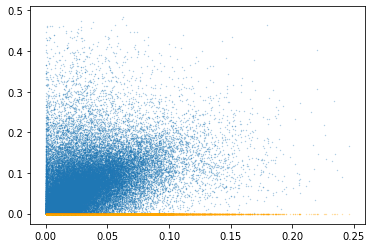

In [16]:
CN = ConvexNet(T, X, Y, kernel_num=100, hidden_num=100)
Y_pred = CN(T, X)
plt.scatter(T, Y, s=0.1, alpha=0.5)
plt.scatter(T.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

Epoch 0: 100%|██████████| 261/261 [01:29<00:00,  2.91batch/s, MSE=0.000404, R2=0.869]


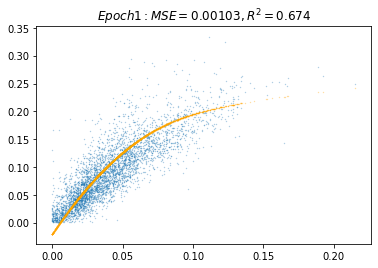

Epoch 1: 100%|██████████| 261/261 [01:04<00:00,  4.06batch/s, MSE=0.00112, R2=0.537] 


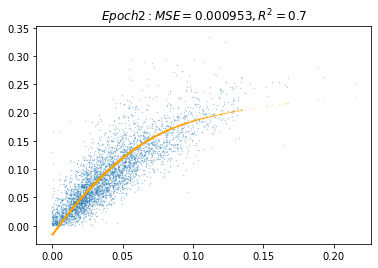

Epoch 2: 100%|██████████| 261/261 [01:28<00:00,  2.95batch/s, MSE=0.000826, R2=0.726]


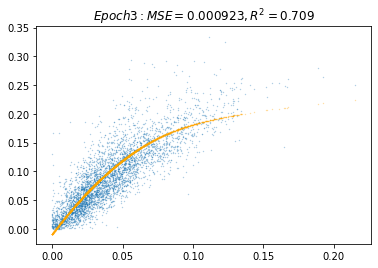

Epoch 3: 100%|██████████| 261/261 [01:09<00:00,  3.76batch/s, MSE=0.0011, R2=0.402]  


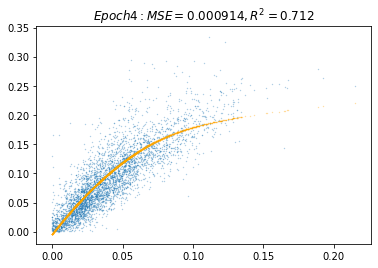

Epoch 4: 100%|██████████| 261/261 [01:05<00:00,  3.99batch/s, MSE=0.000652, R2=0.803]


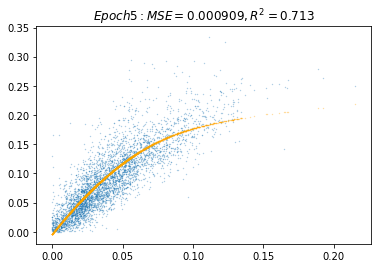

Epoch 5: 100%|██████████| 261/261 [01:29<00:00,  2.90batch/s, MSE=0.00156, R2=0.36]  


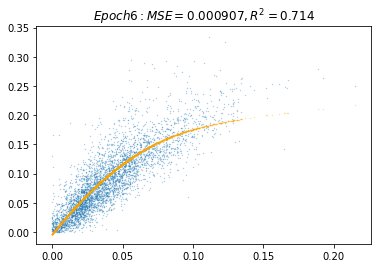

Epoch 6: 100%|██████████| 261/261 [01:27<00:00,  3.00batch/s, MSE=0.000377, R2=0.735]


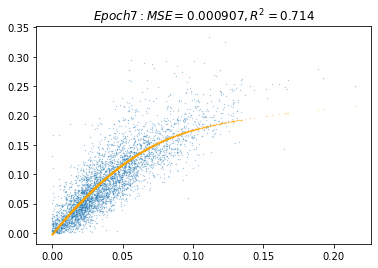

Epoch 7: 100%|██████████| 261/261 [01:09<00:00,  3.75batch/s, MSE=0.00109, R2=0.516]  


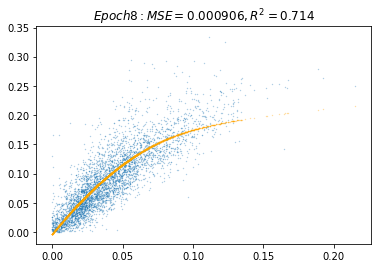

Epoch 8: 100%|██████████| 261/261 [00:59<00:00,  4.35batch/s, MSE=0.001, R2=0.655]    


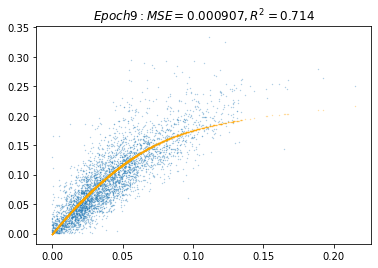

Epoch 9: 100%|██████████| 261/261 [01:25<00:00,  3.05batch/s, MSE=0.000974, R2=0.677]


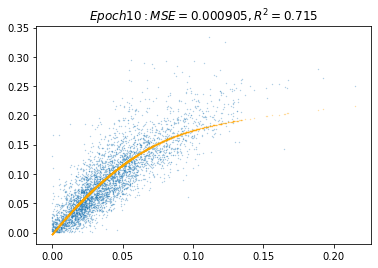

Epoch 10: 100%|██████████| 261/261 [01:14<00:00,  3.50batch/s, MSE=0.000509, R2=0.882]


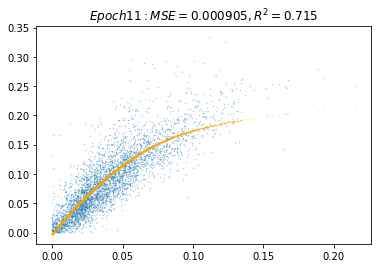

Epoch 11: 100%|██████████| 261/261 [01:06<00:00,  3.91batch/s, MSE=0.00067, R2=0.796] 


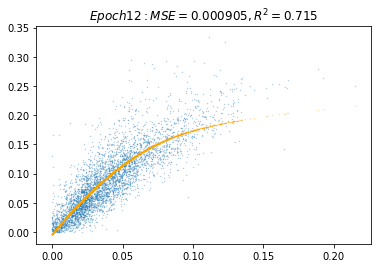

Epoch 12: 100%|██████████| 261/261 [01:18<00:00,  3.34batch/s, MSE=0.000515, R2=0.738] 


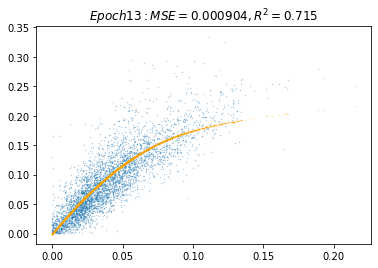

Epoch 13: 100%|██████████| 261/261 [01:01<00:00,  4.22batch/s, MSE=0.000759, R2=0.689]


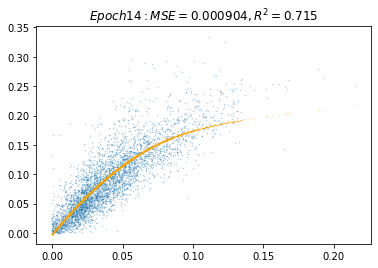

Epoch 14: 100%|██████████| 261/261 [00:58<00:00,  4.48batch/s, MSE=0.00108, R2=0.731] 


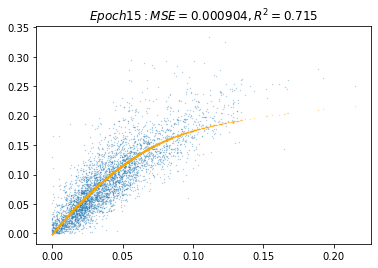

Epoch 15: 100%|██████████| 261/261 [01:00<00:00,  4.30batch/s, MSE=0.000713, R2=0.737]


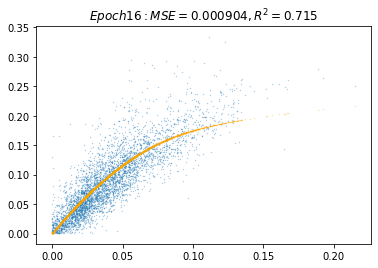

Epoch 16: 100%|██████████| 261/261 [00:57<00:00,  4.55batch/s, MSE=0.000856, R2=0.759]


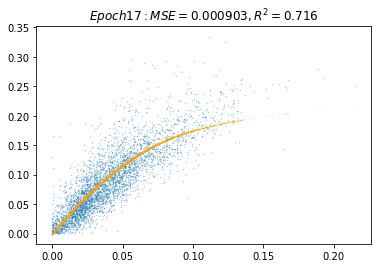

Epoch 17: 100%|██████████| 261/261 [01:00<00:00,  4.32batch/s, MSE=0.000692, R2=0.697]


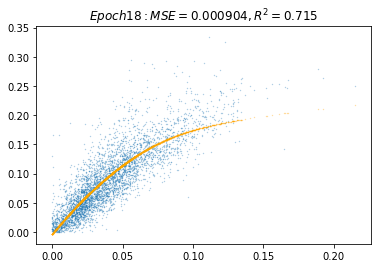

Epoch 18:  54%|█████▍    | 142/261 [01:05<00:54,  2.17batch/s, MSE=0.000592, R2=0.808]


KeyboardInterrupt: 

In [15]:
TX = torch.concatenate((T, X), axis=1)
loader = data.DataLoader(dataset=data.TensorDataset(TX, Y), batch_size=16, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(CN.parameters())

CN.train()
for epoch in range(10000):
    with tqdm(loader, unit="batch") as tepoch:
        for batch_tx, batch_y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            batch_t = batch_tx[:, 0].reshape(-1, 1)
            batch_x = batch_tx[:, 1:]
            y_pred = CN(batch_t, batch_x)
            loss = loss_fn(y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            r2 = r2_score(y_pred, batch_y)
            tepoch.set_postfix(MSE=loss.item(), R2=r2.item())
            sleep(0.0001)
    period = 1
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(T, X)
        plt.scatter(T, Y, s=0.1, alpha=0.5)
        plt.scatter(T.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title('$Epoch %d: MSE=%.3g, R^2=%.3g$' % (epoch + 1, loss_fn(Y_pred, Y), r2_score(Y_pred, Y)))
        plt.show()

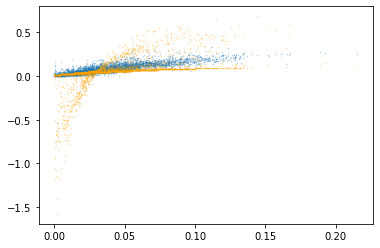

In [23]:
CN = ConvexNet(T, X, Y, kernel_num=4, hidden_num=10)
Y_pred = CN(T, X)
plt.scatter(T, Y, s=0.1, alpha=0.5)
plt.scatter(T.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

Epoch 0: 100%|██████████| 261/261 [00:44<00:00,  5.90batch/s, MSE=0.000936, R2=0.409]


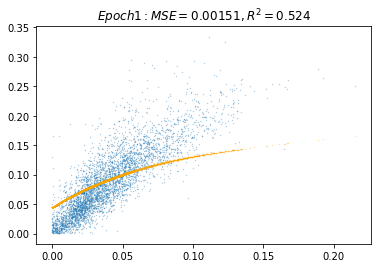

Epoch 1: 100%|██████████| 261/261 [00:44<00:00,  5.80batch/s, MSE=0.00217, R2=0.475] 


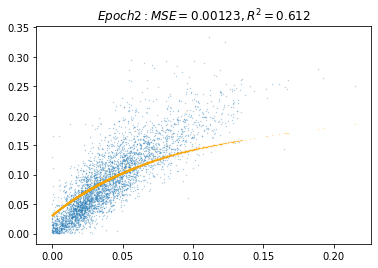

Epoch 2: 100%|██████████| 261/261 [00:44<00:00,  5.83batch/s, MSE=0.00086, R2=0.717] 


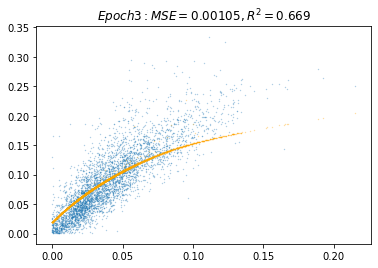

Epoch 3: 100%|██████████| 261/261 [00:45<00:00,  5.71batch/s, MSE=0.000692, R2=0.795]


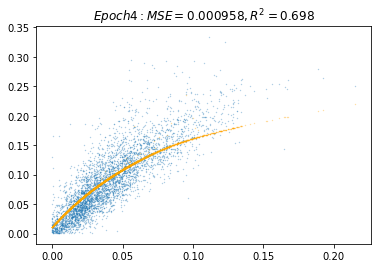

Epoch 4: 100%|██████████| 261/261 [00:44<00:00,  5.89batch/s, MSE=0.00155, R2=0.663] 


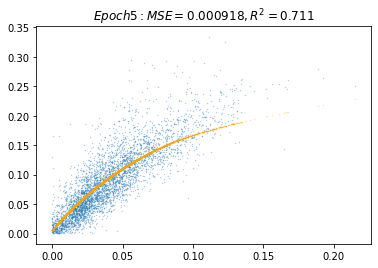

Epoch 5:  56%|█████▋    | 147/261 [00:25<00:19,  5.86batch/s, MSE=0.000435, R2=0.854]


KeyboardInterrupt: 

In [24]:
TX = torch.concatenate((T, X), axis=1)
loader = data.DataLoader(dataset=data.TensorDataset(TX, Y), batch_size=16, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(CN.parameters())

CN.train()
for epoch in range(10000):
    with tqdm(loader, unit="batch") as tepoch:
        for batch_tx, batch_y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            batch_t = batch_tx[:, 0].reshape(-1, 1)
            batch_x = batch_tx[:, 1:]
            y_pred = CN(batch_t, batch_x)
            loss = loss_fn(y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            r2 = r2_score(y_pred, batch_y)
            tepoch.set_postfix(MSE=loss.item(), R2=r2.item())
            sleep(0.0001)
    period = 1
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(T, X)
        plt.scatter(T, Y, s=0.1, alpha=0.5)
        plt.scatter(T.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title('$Epoch %d: MSE=%.3g, R^2=%.3g$' % (epoch + 1, loss_fn(Y_pred, Y), r2_score(Y_pred, Y)))
        plt.show()

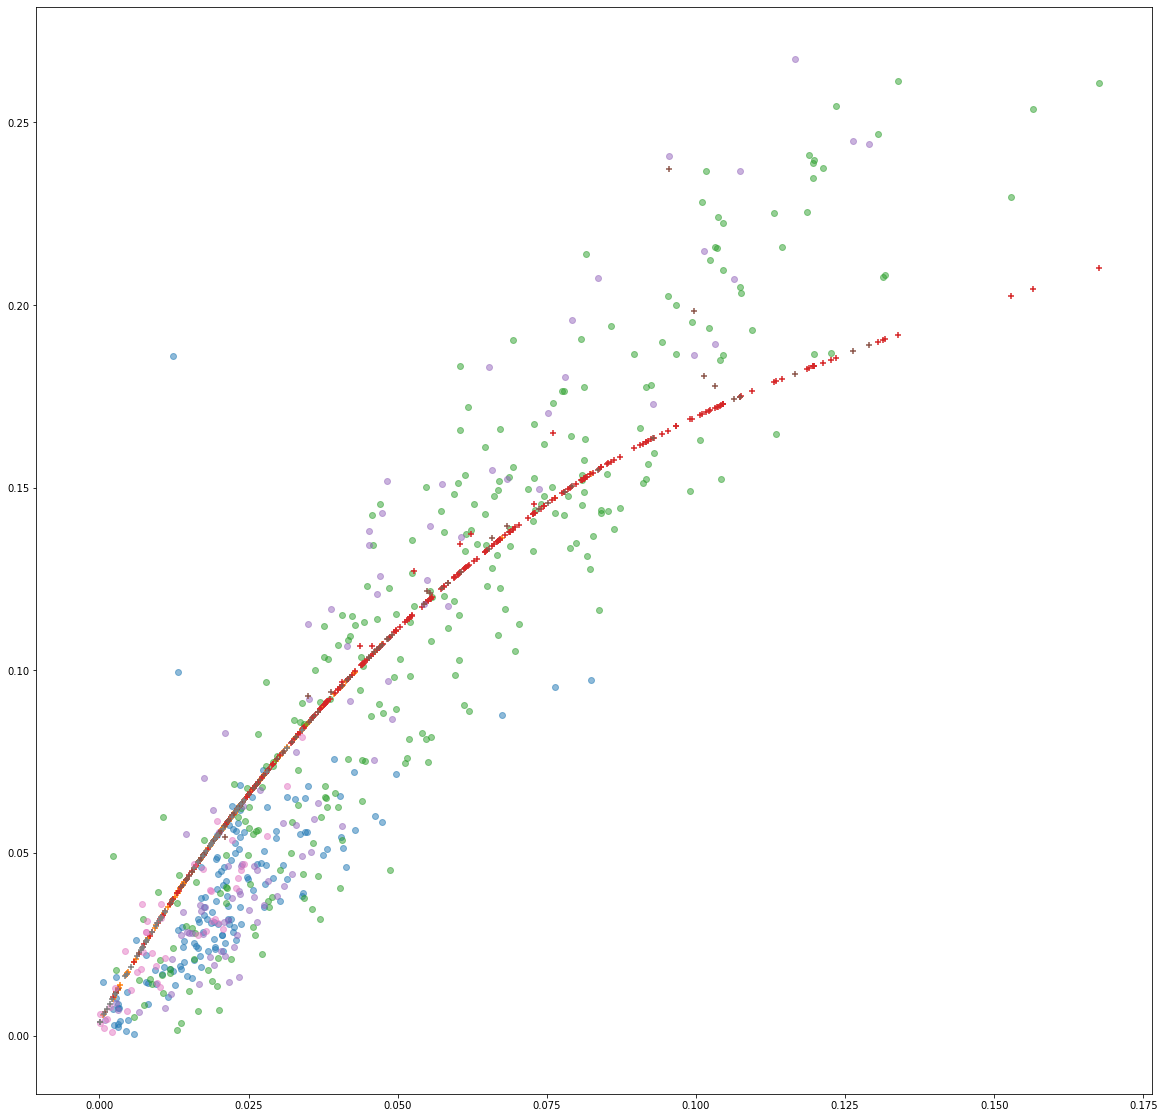

In [37]:
for city in range(1, 5):
    T1 = torch.from_numpy(df[df['city_id'] == city]['delta_hufan_rate'].values).reshape(-1, 1)
    X1 = torch.from_numpy(df[df['city_id'] == city][feature_columns].values)
    Y1 = torch.from_numpy(df[df['city_id'] == city]['dgmv_ratio'].values).reshape(-1, 1)
    Y_pred1 = CN(T1, X1)
    plt.figure(num=1, figsize=(20, 20))
    plt.scatter(T1, Y1, alpha=0.5)
    plt.scatter(T1.detach().numpy(), Y_pred1.detach().numpy(), marker='+')
plt.show()